In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import csv

In [6]:
def plot_series(x, y, format="-", start=0, end=None, title=None, xlabel=None, ylabel=None, legend=None ):
    """
    Visualizes time series data

    Args:
      x (array of int) - contains values for the x-axis
      y (array of int or tuple of arrays) - contains the values for the y-axis
      format (string) - line style when plotting the graph
      label (string) - tag for the line
      start (int) - first time step to plot
      end (int) - last time step to plot
      title (string) - title of the plot
      xlabel (string) - label for the x-axis
      ylabel (string) - label for the y-axis
      legend (list of strings) - legend for the plot
    """

    # Setup dimensions of the graph figure
    plt.figure(figsize=(15, 4))
    
    # Check if there are more than two series to plot
    if type(y) is tuple:

      # Loop over the y elements
      for y_curr in y:

        # Plot the x and current y values
        plt.plot(x[start:end], y_curr[start:end], format)

    else:
      # Plot the x and y values
      plt.plot(x[start:end], y[start:end], format)

    # Label the x-axis
    plt.xlabel(xlabel)

    # Label the y-axis
    plt.ylabel(ylabel)

    # Set the legend
    if legend:
      plt.legend(legend)

    # Set the title
    plt.title(title)

    # Overlay a grid on the graph
    plt.grid(True)

    # Draw the graph on screen
    plt.show()

In [7]:
import requests

url = "https://storage.googleapis.com/tensorflow-1-public/course4/Sunspots.csv"
response = requests.get(url)

with open("Sunspots.csv", "wb") as file:
    file.write(response.content)

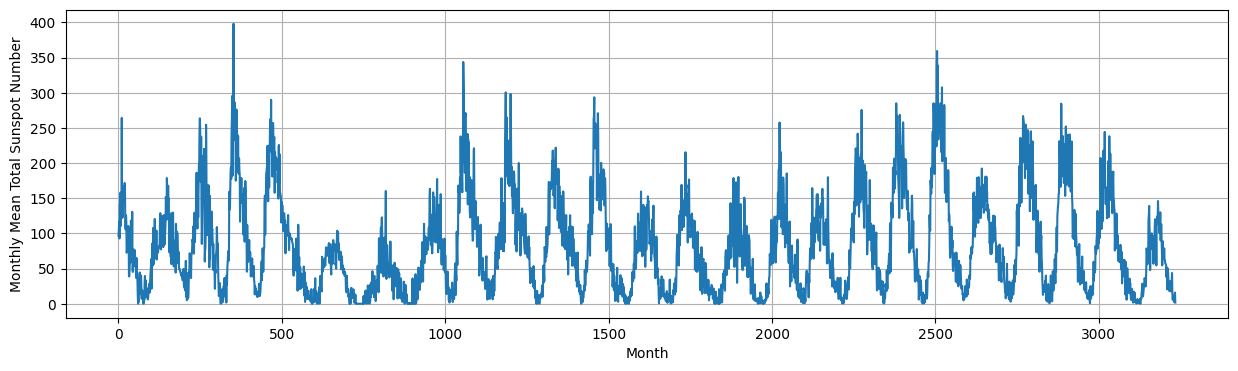

In [8]:
# Initialize lists
time_step = []
sunspots = []

# Open CSV file
with open('./Sunspots.csv') as csvfile:
  
  # Initialize reader
  reader = csv.reader(csvfile, delimiter=',')
  
  # Skip the first line
  next(reader)
  
  # Append row and sunspot number to lists
  for row in reader:
    time_step.append(int(row[0]))
    sunspots.append(float(row[2]))

# Convert lists to numpy arrays
time = np.array(time_step)
series = np.array(sunspots)

# Preview the data
plot_series(time, series, xlabel='Month', ylabel='Monthly Mean Total Sunspot Number')

In [9]:
# Define the split time
split_time = 3000

# Get the train set 
time_train = time[:split_time]
x_train = series[:split_time]

# Get the validation set
time_valid = time[split_time:]
x_valid = series[split_time:]

In [10]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    """Generates dataset windows

    Args:
      series (array of float) - contains the values of the time series
      window_size (int) - the number of time steps to include in the feature
      batch_size (int) - the batch size
      shuffle_buffer(int) - buffer size to use for the shuffle method

    Returns:
      dataset (TF Dataset) - TF Dataset containing time windows
    """
  
    # Generate a TF Dataset from the series values
    dataset = tf.data.Dataset.from_tensor_slices(series)
    
    # Window the data but only take those with the specified size
    dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)
    
    # Flatten the windows by putting its elements in a single batch
    dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))

    # Create tuples with features and labels 
    dataset = dataset.map(lambda window: (window[:-1], window[-1]))

    # Shuffle the windows
    dataset = dataset.shuffle(shuffle_buffer)
    
    # Create batches of windows
    dataset = dataset.batch(batch_size)
    
    # Optimize the dataset for training
    dataset = dataset.cache().prefetch(1)
    
    return dataset

In [11]:
# Parameters
window_size = 30
batch_size = 32
shuffle_buffer_size = 1000

# Generate the dataset windows
train_set = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)

In [12]:
# Build the model
model = tf.keras.models.Sequential([
    tf.keras.Input(shape=(window_size,)),
    tf.keras.layers.Dense(30, activation="relu"), 
    tf.keras.layers.Dense(10, activation="relu"),
    tf.keras.layers.Dense(1)
])

# Print the model summary
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 30)             │           930 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │           310 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            11 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,251 (4.89 KB)

 Trainable params: 1,251 (4.89 KB)

 Non-trainable params: 0 (0.00 B)

In [13]:
# Set the learning rate scheduler
lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * 10**(epoch / 20))

# Initialize the optimizer
optimizer = tf.keras.optimizers.SGD(momentum=0.9)

# Set the training parameters
model.compile(loss=tf.keras.losses.Huber(), optimizer=optimizer)

# Train the model
history = model.fit(train_set, epochs=100, callbacks=[lr_schedule])

Epoch 1/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 115.4018 - learning_rate: 1.0000e-08
Epoch 2/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 605us/step - loss: 113.9361 - learning_rate: 1.1220e-08
Epoch 3/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 584us/step - loss: 112.2393 - learning_rate: 1.2589e-08
Epoch 4/100
 1/93 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 99.9081

c:\Users\Reza Behzadi\AppData\Local\Programs\Python\Python311\Lib\contextlib.py:155: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 674us/step - loss: 110.3311 - learning_rate: 1.4125e-08
Epoch 5/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 631us/step - loss: 108.1754 - learning_rate: 1.5849e-08
Epoch 6/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 598us/step - loss: 105.7624 - learning_rate: 1.7783e-08
Epoch 7/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 610us/step - loss: 103.0456 - learning_rate: 1.9953e-08
Epoch 8/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 576us/step - loss: 99.9916 - learning_rate: 2.2387e-08
Epoch 9/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 614us/step - loss: 96.6050 - learning_rate: 2.5119e-08
Epoch 10/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 761us/step - loss: 92.8520 - learning_rate: 2.8184e-08
Epoch 11/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 619us/step - loss: 88.7160 - learning_rate: 3.1623e-08
Epoch 12/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 630us/step - loss: 84.2291 - learning_rate: 3.5481e-08
Epoch 13/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 554us/step - loss: 79.5076 - learning_rate: 3.9811e-08
Epoch 14/100
93/93 ━━━━━━━━━━━━━━━

(1e-08, 0.001, 0.0, 100.0)

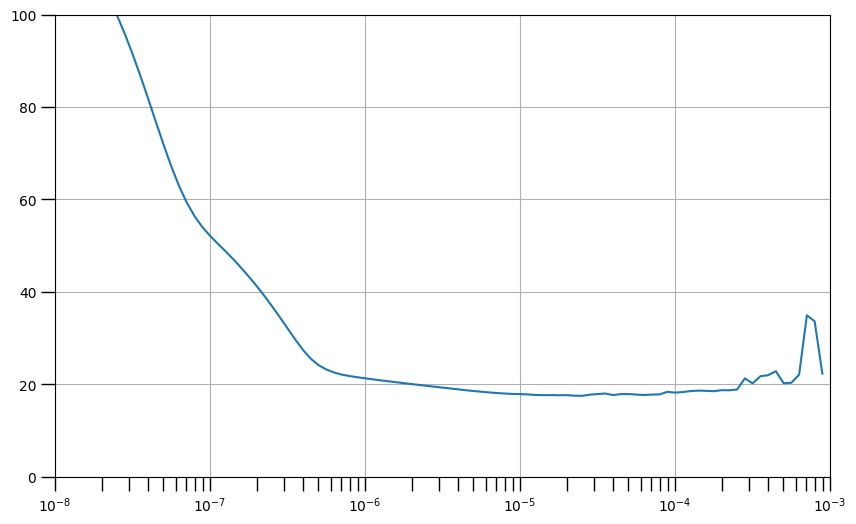

In [14]:
# Define the learning rate array
lrs = 1e-8 * (10 ** (np.arange(100) / 20))

# Set the figure size
plt.figure(figsize=(10, 6))

# Set the grid
plt.grid(True)

# Plot the loss in log scale
plt.semilogx(lrs, history.history["loss"])

# Increase the tickmarks size
plt.tick_params('both', length=10, width=1, which='both')

# Set the plot boundaries
plt.axis([1e-8, 1e-3, 0, 100])

In [15]:
# Reset states generated by Keras
tf.keras.backend.clear_session()

# Build the Model
model = tf.keras.models.Sequential([
    tf.keras.Input(shape=(window_size,)),
    tf.keras.layers.Dense(30, activation="relu"), 
    tf.keras.layers.Dense(10, activation="relu"),
    tf.keras.layers.Dense(1)
])

In [16]:
# Set the learning rate
learning_rate = 2e-5

# Set the optimizer 
optimizer = tf.keras.optimizers.SGD(learning_rate=learning_rate, momentum=0.9)

# Set the training parameters
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])

# Train the model
history = model.fit(train_set,epochs=100)

Epoch 1/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 717us/step - loss: 54.5488 - mae: 55.0441
Epoch 2/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 620us/step - loss: 21.5245 - mae: 22.0169
Epoch 3/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 630us/step - loss: 20.0483 - mae: 20.5389
Epoch 4/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 631us/step - loss: 19.4150 - mae: 19.9084
Epoch 5/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 620us/step - loss: 18.9738 - mae: 19.4671
Epoch 6/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 606us/step - loss: 18.7903 - mae: 19.2844
Epoch 7/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 620us/step - loss: 18.5575 - mae: 19.0516
Epoch 8/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 967us/step - loss: 18.3492 - mae: 18.8423
Epoch 9/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 696us/step - loss: 18.2026 - mae: 18.6956
Epoch 10/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 620us/step - loss: 18.0526 - mae: 18.5451
Epoch 11/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 663us/step - loss: 17.9507 - mae: 18.4432
Epoch 12/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 620us/step - loss: 17.9042 - ma

In [17]:
def model_forecast(model, series, window_size, batch_size):
    """Uses an input model to generate predictions on data windows

    Args:
      model (TF Keras Model) - model that accepts data windows
      series (array of float) - contains the values of the time series
      window_size (int) - the number of time steps to include in the window
      batch_size (int) - the batch size

    Returns:
      forecast (numpy array) - array containing predictions
    """

    # Generate a TF Dataset from the series values
    dataset = tf.data.Dataset.from_tensor_slices(series)

    # Window the data but only take those with the specified size
    dataset = dataset.window(window_size, shift=1, drop_remainder=True)

    # Flatten the windows by putting its elements in a single batch
    dataset = dataset.flat_map(lambda w: w.batch(window_size))
    
    # Create batches of windows
    dataset = dataset.batch(batch_size).prefetch(1)
    
    # Get predictions on the entire dataset
    forecast = model.predict(dataset, verbose=0)
    
    return forecast

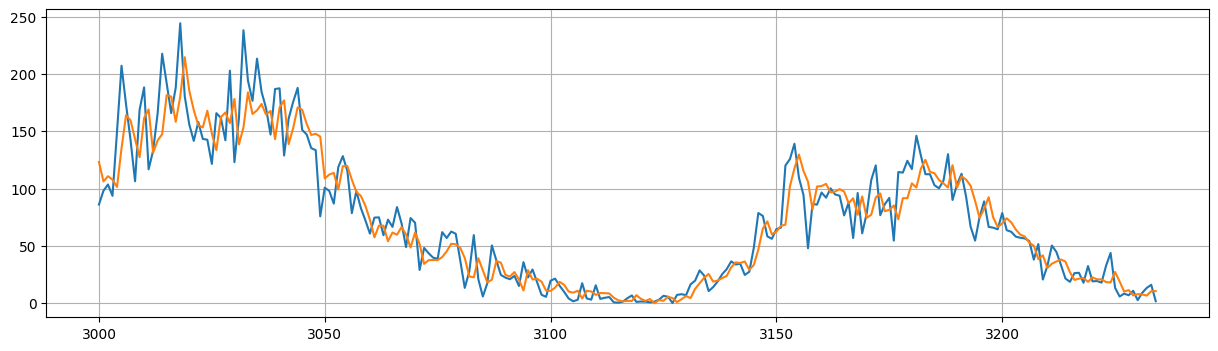

In [18]:
# Reduce the original series
forecast_series = series[split_time-window_size:-1]

# Use helper function to generate predictions
forecast = model_forecast(model, forecast_series, window_size, batch_size)

# Drop single dimensional axis
results = forecast.squeeze()

# Plot the results
plot_series(time_valid, (x_valid, results))

In [19]:
# Compute the MAE
print(tf.keras.metrics.mae(x_valid, results).numpy())

14.794645
